In [1]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten

/var/folders/_6/yv4vw9w5033442shh7vwzfb40000gn/T/ipykernel_93450/2397208556.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [2]:
import os
import cv2
from tqdm import tqdm  # To show progress bar during the image loading process

# Paths to 'yes' and 'no' folders
yes_folder = "Brain_Tumor_Detection/yes"
no_folder = "Brain_Tumor_Detection/no"

# Initialize lists to store images and labels
X = []
y = []

# Function to load images from a given folder and label them
def load_images_from_folder(folder, label):
    for img_name in tqdm(os.listdir(folder)):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        if img is not None:  # Check if the image was loaded successfully
            img = cv2.resize(img, (224, 224))
            X.append(img)
            y.append(label)
        else:
            print(f"Warning: Could not load image {img_name}")

# Load images from 'yes' folder (Tumor present)
print("Loading images from 'yes' folder...")
load_images_from_folder(yes_folder, 'Y')

# Load images from 'no' folder (No tumor)
print("Loading images from 'no' folder...")
load_images_from_folder(no_folder, 'N')

# Check the length of images and labels
print(f"Number of images: {len(X)}")
print(f"Number of labels: {len(y)}")


Loading images from 'yes' folder...


100%|██████████| 1500/1500 [00:01<00:00, 1072.20it/s]


Loading images from 'no' folder...


100%|██████████| 1500/1500 [00:00<00:00, 1500.11it/s]

Number of images: 3000
Number of labels: 3000


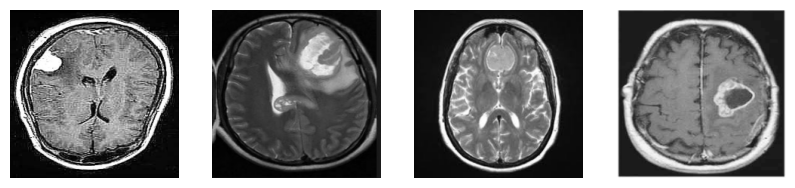

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)

Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [5]:
#preprocessing steps
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [6]:
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (2010, 224, 224, 3)
X_test Shape:  (990, 224, 224, 3)
y_train Shape:  (2010, 2)
y_test Shape:  (990, 2)


In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Multiply, Input, Lambda
from tensorflow.keras.models import Model

# Input layer
input_shape = (224, 224, 3)
inputs = Input(shape=input_shape)

# Load pre-trained models without top layers (no dense layers at the top)
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
xception = Xception(include_top=False, weights='imagenet', input_shape=input_shape)

# Freeze the layers of the pre-trained models (optional)
for layer in vgg16.layers:
    layer.trainable = False

for layer in resnet50.layers:
    layer.trainable = False

for layer in xception.layers:
    layer.trainable = False

# Extract features from the models
vgg16_output = vgg16(inputs)
resnet50_output = resnet50(inputs)
xception_output = xception(inputs)

# Global Average Pooling layers to reduce dimensions
vgg16_output = GlobalAveragePooling2D()(vgg16_output)
resnet50_output = GlobalAveragePooling2D()(resnet50_output)
xception_output = GlobalAveragePooling2D()(xception_output)

# Introduce trainable weights for each model's output
vgg16_weight = tf.Variable(1.0, trainable=True, dtype=tf.float32, name='vgg16_weight')
resnet50_weight = tf.Variable(1.0, trainable=True, dtype=tf.float32, name='resnet50_weight')
xception_weight = tf.Variable(1.0, trainable=True, dtype=tf.float32, name='xception_weight')

# Reshape weights to match the dimension of the feature vectors
vgg16_weight_reshaped = Lambda(lambda x: tf.reshape(x, (1,)))(vgg16_weight)
resnet50_weight_reshaped = Lambda(lambda x: tf.reshape(x, (1,)))(resnet50_weight)
xception_weight_reshaped = Lambda(lambda x: tf.reshape(x, (1,)))(xception_weight)

# Multiply each output by its corresponding weight (broadcasting the scalar weight)
vgg16_weighted_output = Multiply()([vgg16_output, vgg16_weight_reshaped])
resnet50_weighted_output = Multiply()([resnet50_output, resnet50_weight_reshaped])
xception_weighted_output = Multiply()([xception_output, xception_weight_reshaped])

# Concatenate the weighted outputs
combined_output = Concatenate()([vgg16_weighted_output, resnet50_weighted_output, xception_weighted_output])

# Add fully connected layers (Dense layers)
x = Dense(1024, activation='relu')(combined_output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)

# Output layer (for classification, adjust for the number of classes in your problem)
output = Dense(2, activation='softmax')(x)  # Example: 10 classes

# Create the hybrid model
hybrid_model = Model(inputs=inputs, outputs=output)

# Compile the model
hybrid_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
hybrid_model.summary()

# Now you can train the model with your data
# Example: hybrid_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=10)


The following Variables were used a Lambda layer's call (lambda), but
are not present in its tracked objects:
  <tf.Variable 'vgg16_weight:0' shape=() dtype=float32, numpy=1.0>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_1), but
are not present in its tracked objects:
  <tf.Variable 'resnet50_weight:0' shape=() dtype=float32, numpy=1.0>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (lambda_2), but
are not present in its tracked objects:
  <tf.Variable 'xception_weight:0' shape=() dtype=float32, numpy=1.0>
It is possible that this is intended behavior, but it is more lik

In [8]:
import tensorflow as tf

class WeightsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Access the trainable variables directly
        vgg16_w = hybrid_model.trainable_variables[0].numpy()  # VGG16 weight
        resnet50_w = hybrid_model.trainable_variables[1].numpy()  # ResNet50 weight
        xception_w = hybrid_model.trainable_variables[2].numpy()  # Xception weight

        print(f"Epoch {epoch + 1}: VGG16 weight: {vgg16_w}, ResNet50 weight: {resnet50_w}, Xception weight: {xception_w}")

# Add the callback to your training process
history = hybrid_model.fit(X_train, y_train,
                           epochs=5,
                           validation_data=(X_test, y_test),
                           verbose=1,
                           initial_epoch=0,
                           callbacks=[WeightsCallback()])


Epoch 1/5
63/63 [==============================] - ETA: 0s - loss: 1.4582 - accuracy: 0.7552Epoch 1: VGG16 weight: [[ 0.01501139 -0.01219471 -0.02886691 ...  0.03349851  0.00417232
   0.0093439 ]
 [-0.02798133  0.03087691  0.00279533 ...  0.00305043  0.01151816
   0.00078167]
 [-0.02309471  0.02987565 -0.00501459 ...  0.02754438  0.00934442
   0.02491786]
 ...
 [ 0.02234136  0.0174469  -0.03016742 ...  0.01189535  0.03015109
   0.02137884]
 [-0.02728527  0.00571749 -0.03706935 ... -0.0204701  -0.01878614
  -0.01144933]
 [ 0.01560416  0.03325592  0.00377    ... -0.03053615 -0.00276136
  -0.00718115]], ResNet50 weight: [-0.00598529  0.00503995  0.00151607 ...  0.00172511 -0.00249446
 -0.00819436], Xception weight: [[ 2.1077029e-02  2.6452221e-02 -5.6657262e-02 ...  3.7460998e-02
  -3.3129960e-02  3.3998188e-02]
 [-1.6970661e-02 -3.5744816e-02  4.3545019e-02 ... -1.4314748e-05
   1.5252092e-02 -4.7656514e-02]
 [-5.8550652e-02  1.1967801e-02  4.3325882e-02 ...  2.2089196e-02
  -1.9758422e-

In [9]:
# Assuming vgg16_weight, resnet50_weight, and xception_weight were defined as tf.Variable()

# After training, get the final values of the weights
vgg16_weight_value = vgg16_weight.numpy()
resnet50_weight_value = resnet50_weight.numpy()
xception_weight_value = xception_weight.numpy()

print(f"Final VGG16 weight: {vgg16_weight_value}")
print(f"Final ResNet50 weight: {resnet50_weight_value}")
print(f"Final Xception weight: {xception_weight_value}")


Final VGG16 weight: 1.0
Final ResNet50 weight: 1.0
Final Xception weight: 1.0


In [10]:
for variable in hybrid_model.trainable_variables:
    print(f"{variable.name}: {variable.numpy()}")


dense/kernel:0: [[ 0.01500001 -0.00697053 -0.04930935 ...  0.03159813  0.00457845
   0.0093261 ]
 [-0.0279927   0.02789355 -0.00283178 ...  0.00132626  0.01120445
   0.00076266]
 [-0.02310609  0.02209129  0.00770016 ...  0.02526607  0.0087304
   0.0249006 ]
 ...
 [ 0.02234136  0.03490458 -0.0363253  ...  0.01049007  0.03019474
   0.02136782]
 [-0.02729656  0.00457048 -0.04046066 ... -0.0214711  -0.01874568
  -0.01146738]
 [ 0.01560416  0.01939357  0.01332886 ... -0.03470383 -0.00892215
  -0.00719236]]
dense/bias:0: [-5.9966561e-03  4.2210761e-03  1.2490056e-03 ...  6.3963191e-05
 -2.6469014e-03 -8.2115717e-03]
dense_1/kernel:0: [[ 2.1065874e-02  2.6440889e-02 -5.6668554e-02 ...  3.7449680e-02
  -3.3141207e-02  3.4009472e-02]
 [-1.6980391e-02 -3.5756178e-02  4.3416347e-02 ... -4.4114127e-05
   1.5246453e-02 -4.7672823e-02]
 [-5.8541313e-02  1.1956420e-02  3.7264798e-02 ...  2.2077827e-02
  -1.9769741e-02 -1.8311709e-02]
 ...
 [ 2.7135000e-02  1.2486121e-03  4.1775081e-02 ...  1.8208900e

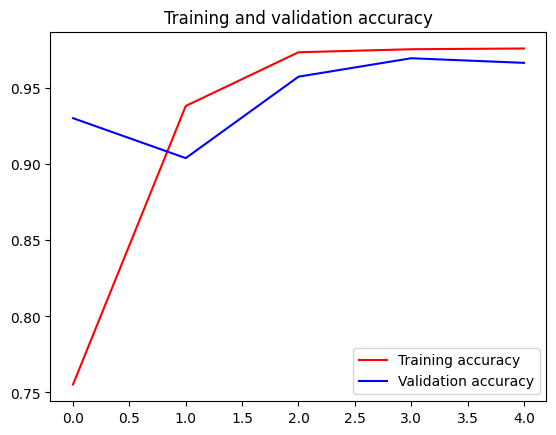

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

31/31 [==============================] - 178s 6s/step


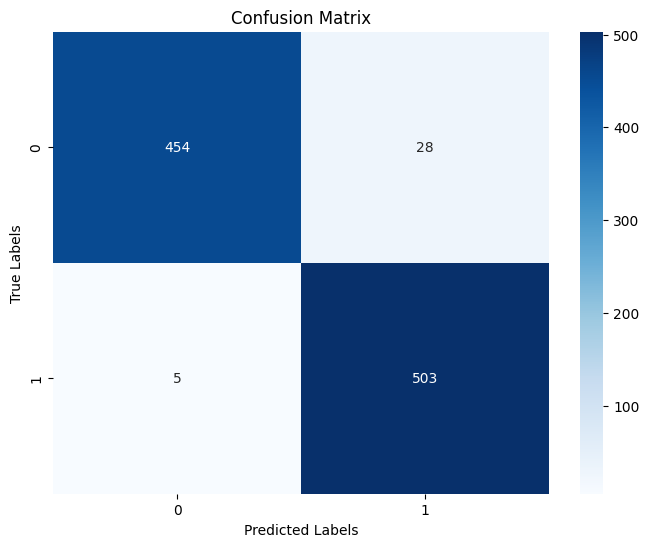

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred = hybrid_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
# Accuracy
accuracy = accuracy_score(y_true, y_pred_classes)

# Precision
precision = precision_score(y_true, y_pred_classes)

# Recall
recall = recall_score(y_true, y_pred_classes)

# F1 Score
f1 = f1_score(y_true, y_pred_classes)

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
# Classification report
report = classification_report(y_true, y_pred_classes, target_names=['No Tumor', 'Tumor'])
print(report)


Accuracy: 0.9667
Precision: 0.9473
Recall: 0.9902
F1 Score: 0.9682
              precision    recall  f1-score   support

    No Tumor       0.99      0.94      0.96       482
       Tumor       0.95      0.99      0.97       508

    accuracy                           0.97       990
   macro avg       0.97      0.97      0.97       990
weighted avg       0.97      0.97      0.97       990

